In [41]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import re
import nltk
# nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger","parser", "ner"])

from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors

import sys
sys.path.insert(0, '..')
from src.preprocess import clean_text
from textwrap import wrap
import pickle

## Import pre-processed data

Write a function to import pre-processed data for modelling. Currently, just reading from a previously saved csv file.


In [16]:
data = pd.read_csv("../data/dev_data.csv")
data['process_text'] = data['text'].apply(lambda x: clean_text(x))
# data['process_text'] = lemmatize_text(data['process_text'])

# data = pd.read_csv("../data/lemmatized_dev_data.csv")

emotions = data['label'].unique().tolist()
emotions.sort()
emotions

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [26]:
# split into train and test dataset. Use only 100k samples to train and use the rest as test
X_train,X_test, y_train, y_test = train_test_split(data['process_text'], data['label'], random_state=0,
                                                   train_size= int(1.5e5), stratify= data['label'])

In [27]:
def preprocess(X, remove_stopwords= False):
    w2v_data = []
    for tt in X:
        if remove_stopwords:
            w2v_data.append([ww for ww in word_tokenize(tt.lower()) if ww not in stop_words])
        else:
            w2v_data.append([ww for ww in word_tokenize(tt.lower())])
    return w2v_data

In [28]:
w2v_train = preprocess(X_train, remove_stopwords= True)
w2v_test = preprocess(X_test, remove_stopwords= True)

model = Word2Vec(w2v_train, min_count = 1, window = 5, vector_size= 300)
model.wv.most_similar('affectionate')

[('compassionate', 0.954961895942688),
 ('hateful', 0.9520337581634521),
 ('submissive', 0.9467794895172119),
 ('considerate', 0.9441692233085632),
 ('hostile', 0.9406910538673401),
 ('unfriendly', 0.9368013143539429),
 ('truthful', 0.9362722635269165),
 ('sympathetic', 0.9343375563621521),
 ('insincere', 0.929573655128479),
 ('victimized', 0.9248496890068054)]

In [29]:
goog_wordvecs = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True, limit=100000)
print([key for key, value in goog_wordvecs.key_to_index.items() if 'affection' in key])
goog_wordvecs.most_similar('affectionate')

['affection', 'affectionate', 'affectionately', 'affections', 'affectionately_known', 'disaffection']


[('playful', 0.6595738530158997),
 ('loving', 0.6079658269882202),
 ('endearing', 0.6056519746780396),
 ('affection', 0.5745200514793396),
 ('flirtatious', 0.55764240026474),
 ('lovable', 0.5493666529655457),
 ('gentle', 0.5466917753219604),
 ('sociable', 0.5462646484375),
 ('good_natured', 0.5455296039581299),
 ('charming', 0.5257826447486877)]

In [30]:
pd.DataFrame(model.wv.most_similar('affectionate'), columns = ['word', 'similarity']).merge(\
    pd.DataFrame(goog_wordvecs.most_similar('affectionate'), columns = ['word', 'similarity']), left_index= True,
    right_index= True, suffixes= ("_custom","_google")).to_csv("../results/w2v_simlarity_affectionate.csv")

In [31]:
# Create a Word2Vec Transformer
class W2VEmbeddings(TransformerMixin):
    def __init__(self, w2v_model= None, weights = None, max_len= None):
        self.w2v_model = w2v_model
        self.weights = weights
        self.word2weight = None

        # add max len parameter
        if max_len is not None:
            self.max_len = max_len
        elif self.w2v_model is not None:
            self.max_len = self.w2v_model.vector_size
        else:
            self.max_len = 100

    def fit(self, X, y=None, **fit_params):
        w2v_X = preprocess(X)

        if self.w2v_model is None:
            print(f"Fitting new Word2Vec model of size {self.max_len} on training data.")
            w2v_model = Word2Vec(w2v_X, min_count = 1, window = 5, vector_size= self.max_len)
            self.w2v_model = w2v_model.wv
            self.max_len = min(self.max_len,self.w2v_model.vector_size)
            print("Done!")
            
        if self.weights == "idf":
            tfidf = TfidfVectorizer(analyzer= lambda x: x)
            tfidf.fit(w2v_X)
            # if a word was never seen - it must be at least as infrequent as any of the known words
            # so the default idf is the max of known idf's
            max_idf = max(tfidf.idf_)
            self.word2weight = defaultdict(
                lambda: max_idf,
                [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
            print("Fit the IDF Model")
        else:
            self.word2weight = defaultdict(lambda: 1)
        return self
    
    def transform(self, X, y=None, **fit_params):
        X_w2v = []
        for vv in preprocess(X):
            X_w2v.append(np.mean([self.w2v_model[w][:self.max_len] * self.word2weight[w] for w in vv 
                    if w in self.w2v_model.key_to_index.keys()] 
                    or [np.zeros(self.max_len)], axis= 0))
        return X_w2v


In [34]:
X_disp = pd.Series(["work is really stressing me out",
                    "i am scared to move to a new city so soon",
                    "i really enjoyed the movie last night",
                    "the surprise party made me feel so cared for",
                    "i feel horrible when i upset someone i love",
                    "i feel dazed and everything seems so blank"],
                    index= ['anger','fear','joy','love','sadness','surprise'])
# X_disp = data.groupby('label').tail(10).groupby('label').head(1).set_index('label')\
#     ['process_text'].apply(lambda x: " ".join(x.split()[:10])).reindex(emotions[::-1])

Fit the IDF Model
Fit the IDF Model


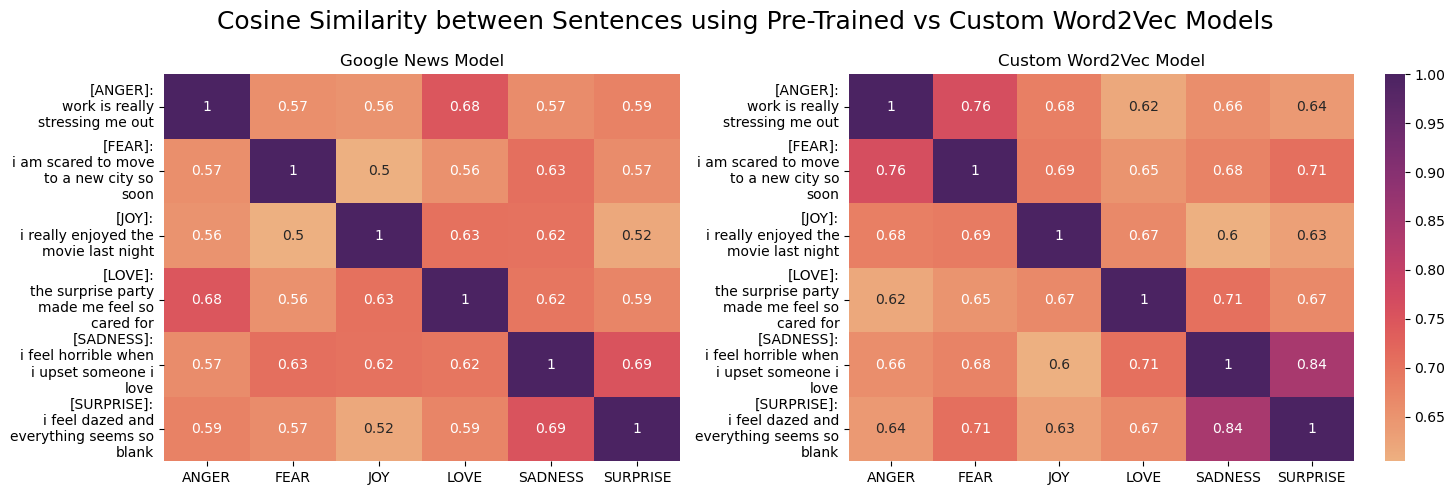

In [35]:
fig,axs = plt.subplots(figsize= (15,5), ncols= 2, width_ratios= [0.45, 0.55])

# re.replace(/((?:.*?\s){2}.*?)\s/g, '\\1\n')
xlabels_new = ["["+ ee.upper()+"]:\n"+'\n'.join(wrap(label, width=20)) for label,ee in zip(X_disp, emotions)]

test_goog = W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300).fit_transform(X_disp)
sns.heatmap(pd.DataFrame(cosine_similarity(test_goog), index = xlabels_new, columns= X_disp.index.str.upper()), annot= True, cbar= False,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[0])
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_title("Google News Model")

test_custom = W2VEmbeddings(weights= 'idf', w2v_model= model.wv, max_len= 300).fit_transform(X_disp)
sns.heatmap(pd.DataFrame(cosine_similarity(test_custom), index = xlabels_new, columns= X_disp.index.str.upper()), annot= True,
            cmap= sns.color_palette("flare", as_cmap=True), ax= axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_title("Custom Word2Vec Model");

plt.suptitle("Cosine Similarity between Sentences using Pre-Trained vs Custom Word2Vec Models", fontsize= 18)
plt.tight_layout();
fig.savefig("../images/word2vec_similarity.png")



In [36]:
pipe_svm = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300)),
    ('clf', SGDClassifier(loss= 'hinge', penalty= 'l2', max_iter= 100))
])
%time pipe_svm.fit(X_train, y_train)
%time y_pred = pipe_svm.predict(X_test)

print(f"SVM accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

# # save SVC classifier
# with open('models/w2v_svc.pkl','wb') as f:
#     pickle.dump(pipe_svm,f)

Fit the IDF Model
CPU times: total: 12.3 s
Wall time: 1min 10s
CPU times: total: 22.5 s
Wall time: 1min 49s
SVM accuracy is: 0.68.

              precision    recall  f1-score   support

       anger       0.64      0.61      0.62     25437
        fear       0.74      0.50      0.60     21568
         joy       0.67      0.86      0.75     61585
        love       0.59      0.29      0.39     14916
     sadness       0.70      0.73      0.71     52961
    surprise       0.67      0.32      0.43      6466

    accuracy                           0.68    182933
   macro avg       0.67      0.55      0.58    182933
weighted avg       0.68      0.68      0.66    182933



In [37]:
pipe_logreg = Pipeline([
    ('w2v', W2VEmbeddings(weights= 'idf', w2v_model= goog_wordvecs, max_len= 300)),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
%time pipe_logreg.fit(X_train, y_train)
%time y_pred = pipe_logreg.predict(X_test)

print(f"Logistic Regression accuracy is: {accuracy_score(y_test, y_pred):0.2f}.\n")
print(classification_report(y_test, y_pred))

# # save log reg classifier
# with open('models/w2v_logreg.pkl','wb') as f:
#     pickle.dump(pipe_logreg,f)

Fit the IDF Model
CPU times: total: 18.4 s
Wall time: 1min 9s
CPU times: total: 17.7 s
Wall time: 1min 7s
Logistic Regression accuracy is: 0.68.

              precision    recall  f1-score   support

       anger       0.68      0.56      0.62     25437
        fear       0.70      0.55      0.62     21568
         joy       0.69      0.83      0.76     61585
        love       0.62      0.33      0.43     14916
     sadness       0.68      0.76      0.72     52961
    surprise       0.66      0.37      0.48      6466

    accuracy                           0.68    182933
   macro avg       0.67      0.57      0.60    182933
weighted avg       0.68      0.68      0.67    182933



In [57]:
y_test_oe = label_binarize(y_test[:-500], classes= emotions)
y_pred_oe = pipe_logreg.predict_proba(X_test[:-500])

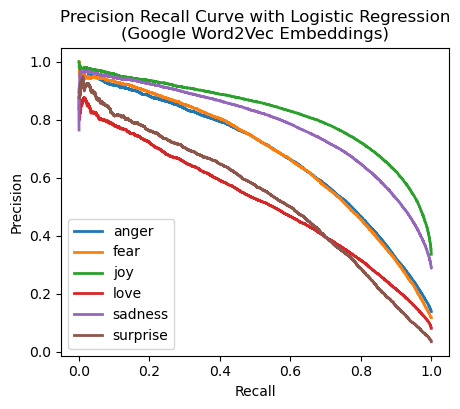

<Figure size 640x480 with 0 Axes>

In [65]:
# roc curve
precision = dict()
recall = dict()

plt.figure(figsize= (5,4))
for i in range(len(emotions)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_oe[:, i],
                                  y_pred_oe[:, i])
    plt.plot(recall[i].tolist()[:-15], precision[i].tolist()[:-15], lw=2, label= f"{emotions[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision Recall Curve with Logistic Regression\n(Google Word2Vec Embeddings)", fontsize= 12)
plt.show()
plt.savefig("../images/w2v_logreg_precision_recall.png")


In [47]:
recall[3]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       6.70421024e-05, 6.70421024e-05, 0.00000000e+00])